# Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from patsy import dmatrices

# Load Data

In [13]:
train = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')

In [3]:
print(train.shape)

(27128, 18)


In [4]:
print(test.shape)

(18083, 17)


In [5]:
train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,939,1,-1,0,unknown,1
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,172,10,-1,0,unknown,1
2,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,567,1,595,2,failure,1
3,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown,1
4,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,502,1,9,2,success,1


In [10]:
def getDayOfYear(month, day):
    return int(datetime.datetime.strptime("{} {}".format(month, day), '%b %d').date().strftime('%j'))

def transformDate(X):
    X["dayofyear"] = np.vectorize(getDayOfYear)(X["month"], X["day"])
    X["dayofweek"] = X["dayofyear"] % 7

In [14]:
transformDate(train)
transformDate(test)

In [15]:
train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,dayofyear,dayofweek
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,939,1,-1,0,unknown,1,93,2
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,172,10,-1,0,unknown,1,49,0
2,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,567,1,595,2,failure,1,103,5
3,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown,1,25,4
4,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,502,1,9,2,success,1,120,1


In [16]:
print("{0:.1f}%".format(train.y.mean() * 100))

11.7%


# Feature Engineering Based on LASSO

In [31]:
y, X = dmatrices(
    "y ~ age + job + marital + education + default + balance + housing + loan + contact + day + month + duration + campaign + pdays + previous + poutcome + dayofyear + dayofweek",
    data=train,
    return_type='dataframe')

In [29]:
X.head()

,Intercept,job[T.blue-collar],job[T.entrepreneur],job[T.housemaid],job[T.management],job[T.retired],job[T.self-employed],job[T.services],job[T.student],job[T.technician],...,poutcome[T.unknown],age,balance,day,duration,campaign,pdays,previous,dayofyear,dayofweek
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,39.0,1756.0,3.0,939.0,1.0,-1.0,0.0,93.0,2.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,51.0,1443.0,18.0,172.0,10.0,-1.0,0.0,49.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,36.0,436.0,13.0,567.0,1.0,595.0,2.0,103.0,5.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,63.0,474.0,25.0,423.0,1.0,-1.0,0.0,25.0,4.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,31.0,354.0,30.0,502.0,1.0,9.0,2.0,120.0,1.0


In [35]:
X = X.drop(labels=["Intercept"], axis=1)
corr = X.corr()

In [36]:
corr

,job[T.blue-collar],job[T.entrepreneur],job[T.housemaid],job[T.management],job[T.retired],job[T.self-employed],job[T.services],job[T.student],job[T.technician],job[T.unemployed],...,poutcome[T.unknown],age,balance,day,duration,campaign,pdays,previous,dayofyear,dayofweek
job[T.blue-collar],1.000000,-0.098292,-0.089670,-0.269079,-0.122376,-0.100004,-0.167935,-0.076214,-0.234463,-0.091166,...,0.024510,-0.045403,-0.054156,-0.022529,0.005908,0.011072,0.018139,-0.020051,-0.093881,-0.012009
job[T.entrepreneur],-0.098292,1.000000,-0.031808,-0.095450,-0.043410,-0.035474,-0.059571,-0.027035,-0.083170,-0.032339,...,0.016741,0.017521,0.019705,0.000493,0.003934,0.001953,-0.014195,-0.006844,0.023954,-0.011062
job[T.housemaid],-0.089670,-0.031808,1.000000,-0.087077,-0.039602,-0.032362,-0.054345,-0.024664,-0.075874,-0.029502,...,0.023804,0.084770,0.004116,0.000194,-0.010372,-0.000506,-0.028079,-0.010539,0.025220,0.003560
job[T.management],-0.269079,-0.095450,-0.087077,1.000000,-0.118837,-0.097112,-0.163079,-0.074010,-0.227683,-0.088530,...,-0.008630,-0.022864,0.073787,0.017793,-0.009806,0.018882,-0.013875,0.013184,0.084882,-0.002299
job[T.retired],-0.122376,-0.043410,-0.039602,-0.118837,1.000000,-0.044166,-0.074167,-0.033660,-0.103549,-0.040263,...,-0.018027,0.447656,0.044341,-0.009911,0.024644,-0.036441,-0.012303,0.005046,0.026922,0.018911
job[T.self-employed],-0.100004,-0.035474,-0.032362,-0.097112,-0.044166,1.000000,-0.060609,-0.027506,-0.084619,-0.032902,...,0.001251,-0.010758,0.017235,0.006658,0.011423,0.003895,-0.014384,-0.002959,0.028495,-0.015153
job[T.services],-0.167935,-0.059571,-0.054345,-0.163079,-0.074167,-0.060609,1.000000,-0.046190,-0.142099,-0.055252,...,0.010147,-0.067086,-0.039370,-0.003227,-0.001033,-0.003580,0.007062,-0.012042,-0.037419,0.001449
job[T.student],-0.076214,-0.027035,-0.024664,-0.074010,-0.033660,-0.027506,-0.046190,1.000000,-0.064489,-0.025075,...,-0.042166,-0.195871,0.001307,-0.013439,-0.009369,-0.021345,0.025159,0.019321,-0.009144,0.016865
job[T.technician],-0.234463,-0.083170,-0.075874,-0.227683,-0.103549,-0.084619,-0.142099,-0.064489,1.000000,-0.077141,...,0.000282,-0.066126,-0.020306,0.029872,-0.006255,0.025561,-0.006521,0.008296,0.045364,0.004000
job[T.unemployed],-0.091166,-0.032339,-0.029502,-0.088530,-0.040263,-0.032902,-0.055252,-0.025075,-0.077141,1.000000,...,0.005644,0.001172,0.009060,-0.000024,0.021198,-0.019626,-0.006487,-0.005428,-0.035960,-0.009306


In [37]:
corr.values[np.tril_indices_from(corr)] = np.nan
corr = corr.stack().dropna()
corr = corr[corr != 1.0]
corr[np.abs(corr) >= 0.4].sort_values()

poutcome[T.unknown]     pdays                    -0.871737
marital[T.married]      marital[T.single]        -0.776361
education[T.secondary]  education[T.tertiary]    -0.659649
poutcome[T.unknown]     previous                 -0.487881
month[T.feb]            dayofyear                -0.446991
poutcome[T.other]       poutcome[T.unknown]      -0.438350
marital[T.single]       age                      -0.426678
job[T.management]       education[T.secondary]   -0.404298
pdays                   previous                  0.421606
contact[T.unknown]      month[T.may]              0.429466
housing[T.yes]          month[T.may]              0.432344
job[T.retired]          age                       0.447656
contact[T.unknown]      month[T.jun]              0.449808
job[T.management]       education[T.tertiary]     0.597931
month[T.nov]            dayofyear                 0.626133
dtype: float64

In [49]:
res = sm.OLS(y, X).fit_regularized()
coef = pd.concat([res.params], axis=1)
coef.columns = ['coef']
coef = coef.sort_values('coef', ascending=False)
coef = coef[np.abs(coef['coef']) > 0.01]
coef

,coef
poutcome[T.success],0.424325
month[T.dec],0.383618
month[T.oct],0.335125
month[T.sep],0.315935
month[T.mar],0.276223
month[T.nov],0.132700
month[T.jun],0.101460
job[T.student],0.098907
month[T.aug],0.068431
education[T.tertiary],0.032361


<AxesSubplot:xlabel='coef', ylabel='name'>

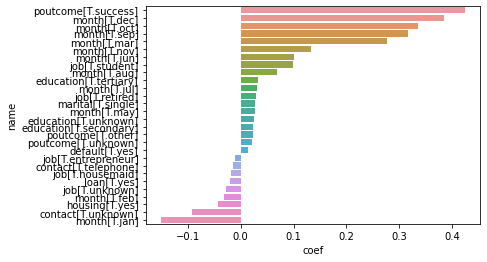

In [50]:
coef['name'] = coef.index.values
sns.barplot(x="coef", y="name", data=coef)

In [54]:
whole = pd.concat([train, test])

count = whole[['month', 'id']].groupby(['month']).agg('count')
count.columns = ['count']

y_month = train[['month', 'y']].groupby(['month']).agg(['sum', 'mean'])
y_month.columns = ['y_sum', 'y_mean']

month = pd.concat([count, y_month], axis=1).sort_values(by=['count'], ascending=False)
month

,count,y_sum,y_mean
month,,,
may,13766,566,0.068053
jul,6895,376,0.090909
aug,6247,425,0.114309
jun,5341,324,0.101124
nov,3970,235,0.100342
apr,2932,337,0.192023
feb,2649,258,0.162673
jan,1403,84,0.099291
oct,738,192,0.437358


<AxesSubplot:xlabel='month', ylabel='y_mean'>

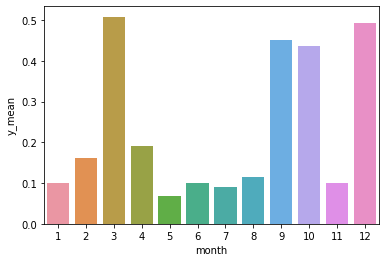

In [55]:
def str2month(str):
    return int(datetime.datetime.strptime("{}".format(str), '%b').date().strftime('%m'))

month['month'] = np.vectorize(str2month)(month.index.values)
sns.barplot(x="month", y="y_mean", data=month)

In [58]:
count = whole[['dayofweek', 'id']].groupby(['dayofweek']).agg('count')
count.columns = ['count']

y_day = train[['dayofweek', 'y']].groupby(['dayofweek']).agg(['sum', 'mean'])
y_day.columns = ['y_sum', 'y_mean']

day = pd.concat([count, y_day], axis=1).sort_values(by=['count'], ascending=False)
day

,count,y_sum,y_mean
dayofweek,,,
1,9493,689,0.120920
0,8895,638,0.118676
2,8647,455,0.088763
6,8156,605,0.122992
3,5394,177,0.054816
5,4064,474,0.194024
4,562,136,0.403561


In [63]:
count = whole[['job', 'id']].groupby(['job']).agg('count')
count.columns = ['count']
job = pd.concat([count, whole.groupby(['job']).agg('mean')], axis=1).sort_values(by=['count'], ascending=False)
job

,count,id,age,balance,day,duration,campaign,pdays,previous,y,dayofyear,dayofweek
job,,,,,,,,,,,,
blue-collar,9732,11872.483354,40.044081,1078.826654,15.442561,262.901562,2.816995,44.033498,0.505138,0.073055,158.553843,2.504624
management,9458,11698.668852,40.449567,1763.616832,16.114189,253.995771,2.864348,38.665468,0.668006,0.136477,183.048953,2.518080
technician,7597,11749.311834,39.314598,1252.632092,16.408582,252.904962,2.906805,37.195077,0.574569,0.106435,178.007240,2.539160
admin.,5171,11633.187778,39.289886,1135.838909,15.564301,246.896732,2.575324,47.859021,0.671630,0.124797,163.976987,2.565461
services,4154,11744.474001,38.740250,997.088108,15.635532,259.318729,2.718344,41.995185,0.501204,0.089385,161.639865,2.517092
retired,2264,11723.926237,61.626767,1984.215106,15.439488,287.361307,2.346731,37.443905,0.638693,0.223580,178.924912,2.613958
self-employed,1579,11803.725142,40.484484,1647.970868,16.027866,268.157061,2.853072,34.747308,0.551615,0.123810,181.693477,2.411020
entrepreneur,1487,11948.172831,42.190989,1521.470074,15.702085,256.309348,2.799597,32.486214,0.478144,0.087527,181.121722,2.440484
unemployed,1303,11664.489639,40.961627,1521.745971,15.498081,288.543361,2.432080,34.146585,0.466616,0.164557,154.088258,2.495012
